<a href="https://colab.research.google.com/github/BenGreenleaf/IA-IB-Google-Colab-Investigations/blob/main/Brachistochrone_Curve_Derivation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

m = 10
g = 9.81
mu = 0.8

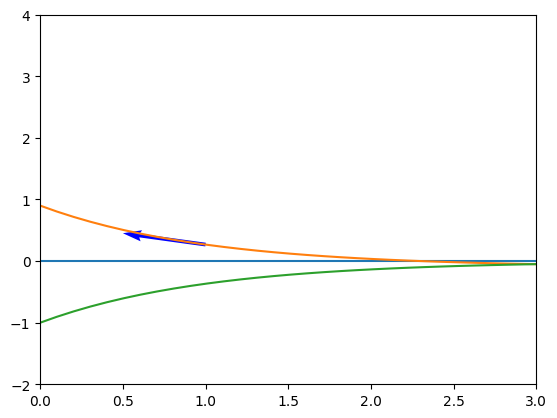

In [ ]:
location = 1
xs = np.linspace(0, 10, 100)

floor = np.zeros(len(xs))
plt.plot(xs, floor)

def curve(x_val):
    return np.exp(-x_val)-0.1

def grad_curve(x_val):
    return -np.exp(-x_val)

def grad2_curve(x):
    return np.exp(-x)

ys = curve(xs)
plt.plot(xs, ys)

fr_vector = grad_curve(xs)
plt.plot(xs, fr_vector)

plt.quiver(
    [location], [curve(location)],
    [-1],        [-grad_curve(location)],
    angles='xy',
    scale_units='xy',
    scale=2,
    color='b'
)

plt.xlim(0, 3)
plt.ylim(-2, 4)
plt.show()


Time when y = 0: 0.2056385474993023


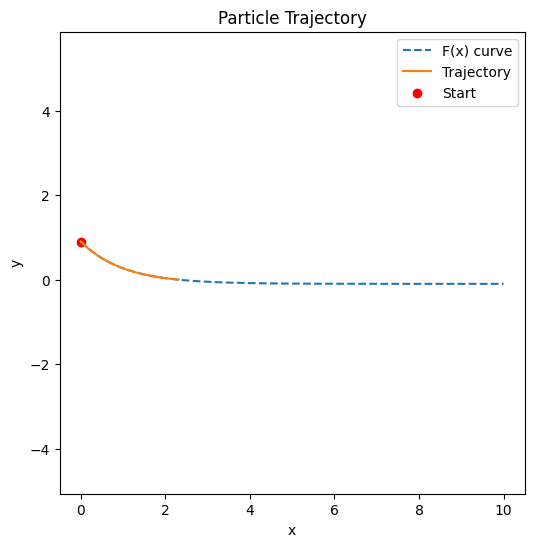

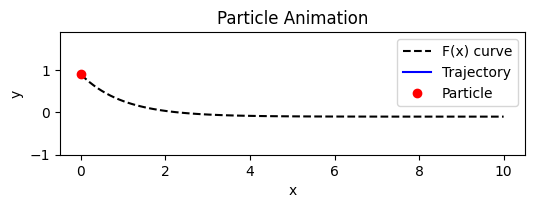

In [ ]:
import matplotlib.animation as animation
from scipy.integrate import solve_ivp
from matplotlib import rc
rc('animation', html='jshtml')

# ---------------------------
# 1. Acceleration field a(r)
# ---------------------------
def acceleration(r, v):
    # r = [x, y], v = [vx, vy]
    x, y = r
    vx, vy = v

    # Gravitational + frictional
    const = (m * g / (grad_curve(x)**2 + 1)) * (grad_curve(x) - mu)
    ax = -const
    ay = -const * grad_curve(x)

    # ----- centripetal acceleration along normal -----
    # speed squared
    sdot2 = vx**2 + vy**2

    # radius of curvature R = (1 + y'^2)^(3/2) / |y''|
    y_prime = grad_curve(x)
    y_double_prime = grad2_curve(x)  # you need to define grad2_curve(x)
    R = (1 + y_prime**2)**(3/2) / np.abs(y_double_prime + 1e-12)  # avoid div 0

    # normal vector (i, -f'(x)) / sqrt(1 + f'(x)^2)
    n_x = -y_prime / np.sqrt(1 + y_prime**2)
    n_y = 1 / np.sqrt(1 + y_prime**2)

    # centripetal acceleration
    ac_x = sdot2 / R * n_x
    ac_y = sdot2 / R * n_y

    # total acceleration
    ax += ac_x
    ay += ac_y

    return np.array([ax, ay])

# ---------------------------
# 2. First-order system for solve_ivp
# ---------------------------
def rhs(t, y):
    x, y_pos, vx, vy = y
    r = np.array([x, y_pos])
    v = np.array([vx, vy])
    a = acceleration(r, v)
    return [vx, vy, a[0], a[1]]

# ---------------------------
# 3. Event: stop when y crosses ground (y=0)
# ---------------------------
def hit_ground(t, y):
    return y[1] + 0.001  # trigger when y=0

hit_ground.terminal = True
hit_ground.direction = -1  # only when decreasing

# ---------------------------
# 4. Initial conditions
# ---------------------------
r0 = np.array([0.0, curve(0)])
v0 = np.array([0.0, 0.0])
y0 = np.hstack([r0, v0])

t_span = (0, 20)
max_step = 0.01

# ---------------------------
# 5. Solve ODE
# ---------------------------
sol = solve_ivp(
    rhs,
    t_span,
    y0,
    events=hit_ground,
    max_step=max_step,
    rtol=1e-8,
    atol=1e-10
)

x = sol.y[0]
y = sol.y[1]
t = sol.t

# ---------------------------
# 6. Find time when y=0 (linear interpolation)
# ---------------------------
idx = np.where(np.sign(y[:-1]) != np.sign(y[1:]))[0][0]
t0 = t[idx] - y[idx] * (t[idx+1] - t[idx]) / (y[idx+1] - y[idx])
print("Time when y = 0:", t0)

# ---------------------------
# 7. Plot trajectory
# ---------------------------
plt.figure(figsize=(6,6))
plt.plot(xs, ys, label="F(x) curve", linestyle='--')
plt.plot(x, y, label="Trajectory")
plt.scatter([r0[0]], [r0[1]], color='red', label="Start")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.title("Particle Trajectory")
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(6,6))

ax.set_xlim(min(xs)-0.5, max(xs)+0.5)
ax.set_ylim(min(y)-1, max(y)+1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Particle Animation")
ax.set_aspect('equal')

# ---------------------------
# Animation function
# ---------------------------
def frame(i):
    ax.clear()  # clear axes each frame

    # plot reference curve
    ax.plot(xs, ys, 'k--', label="F(x) curve")

    # plot trajectory so far
    ax.plot(x[:i+1], y[:i+1], 'b-', label="Trajectory")

    # plot current particle position
    ax.plot(x[i], y[i], 'ro', label="Particle")

    ax.set_xlim(min(xs)-0.5, max(xs)+0.5)
    ax.set_ylim(min(y)-1, max(y)+1)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Particle Animation")
    ax.legend()
    ax.set_aspect('equal')

# ---------------------------
# Create animation
# ---------------------------
ani = animation.FuncAnimation(fig, frame, frames=len(t), interval=20)

In [ ]:
ani